# Analiza przekazu medialnego na temat społeczności LGBT na przykładach portali internetowych

## Ten internet news and opinion services were chosen as a base for analysis. Ideologically portals lean from left to right, with two catholic outlets, one left-wing and one fundamentalist right.

### Aims  
1. Identifying most frequently used words and collocations to learn about the language used in portrayal of LGBT+ issues in polish press. Material can be later used to more detailed, qualitative analysis. 
2. Creation and evaluation of classification model to investigate whether language used in media text is closer to that of right- or left-wing media

### 1. Reading data and preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS 
from langdetect import detect
import spacy
import random
from collections import Counter
import nltk
from nltk.collocations import *
import datetime
import re
import pprint
import gensim
import gensim.corpora as corpora
from add_functions import *

In [2]:
# reading data
data_wpolityce = pd.read_csv(r"wpolityce1.csv").dropna().reset_index().drop("index",axis=1)
data_oko = pd.read_csv(r"oko.csv").dropna().reset_index().drop("index",axis=1)
data_niezalezna = pd.read_csv(r"niezalezna.csv").dropna().reset_index().drop("index",axis=1)
data_krypol = pd.read_csv(r"krypol.csv").dropna().reset_index().drop("index",axis=1)
data_kj = pd.read_csv(r"kj.csv").dropna().reset_index().drop("index",axis=1)
data_gazeta = pd.read_csv(r"gazetapeel.csv",lineterminator="\n").dropna().reset_index().drop("index",axis=1)
data_kontakt = pd.read_csv(r"kontakt.csv").dropna().reset_index().drop("index",axis=1)
data_super_express = pd.read_csv(r"se.csv",lineterminator="\n").dropna().reset_index().drop("index",axis=1)
data_pch24 = pd.read_csv(r"pch241.csv",encoding="utf8").dropna().reset_index().drop("index",axis=1)

In [3]:
#removing authors bio from OKO_press articles
data_oko.drop(131,axis=0,inplace=True)
data_oko = data_oko.reset_index().drop("index",axis=1)

for i in range(len(data_oko.Content)):
    data_oko.Content[i] = str(data_oko.Content[i].split(".")[:-6])

#### Parsing dates to datetime format

In [4]:
data_krypol.Date[0] = datetime.datetime(2020, 12, 26, 0, 0)
data_krypol.Date[1] = datetime.datetime(2020, 12, 21, 0, 0)


In [5]:
data_dict = {"wPolityce.pl":data_wpolityce,
             "OKO.press" : data_oko,
             "Niezalezna.pl":data_niezalezna,
             "Krytyka_Polityczna":data_krypol,
             "Klub_Jagiellonski":data_kj,
             "Gazeta.pl":data_gazeta,
             "Kontakt":data_kontakt,
             "Super_Express":data_super_express,
             "Pch24.pl":data_pch24}
var = 0
for key in data_dict:
    var += 1
    data_dict[key] = parse_dates(data_dict[key])
    
# Removing punctuation signs from texts
punctuation = ["/",".",":",",",")","(","\"","_","-","?","!","...","„","”","–","—","…","[","]","^","'"]
for key in data_dict:
    for i in range(len(data_dict[key].Content)):    
        for sign in punctuation:
            data_dict[key].Content[i] = data_dict[key].Content[i].replace(sign,"")
            data_dict[key].Content[i] = data_dict[key].Content[i].replace("  "," ")


### 2. Exploratory analysis

#### 2.1 Plots showing number of articles on lgbt issues published throughout the year

<ipython-input-6-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


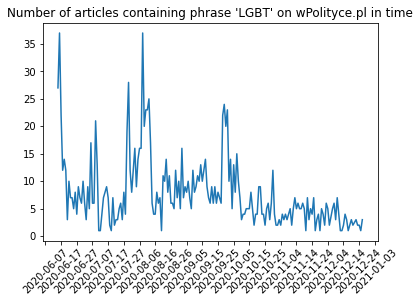

<ipython-input-6-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


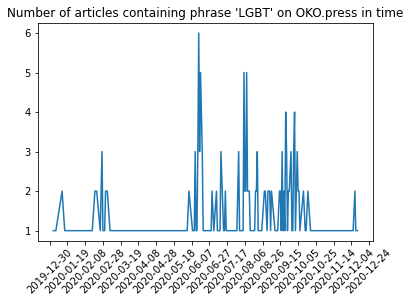

<ipython-input-6-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


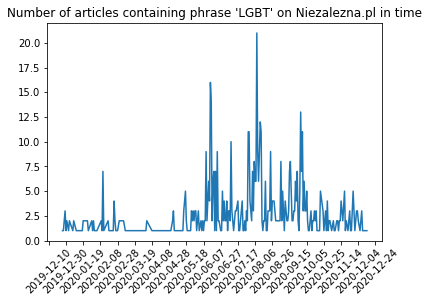

<ipython-input-6-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


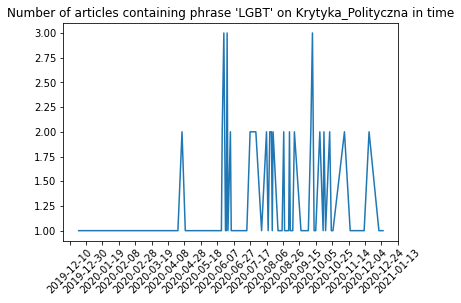

<ipython-input-6-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


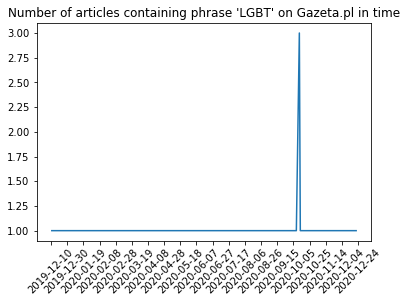

<ipython-input-6-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


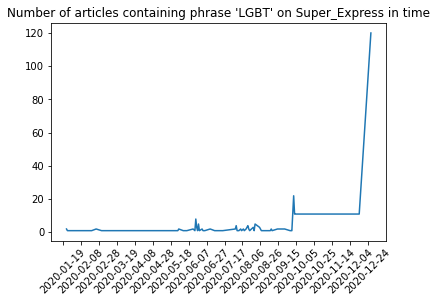

<ipython-input-6-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


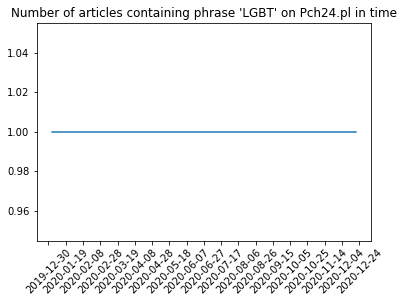

In [6]:

keys = list(data_dict.keys())
for i in range(len(data_dict)):
    if len(data_dict[keys[i]].Content)>100:
        frame = data_dict[keys[i]].sort_values(by="Date")
        grouped = frame.groupby("Date").size()
        plt.plot(grouped.index,grouped.values)
        plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))
        plt.xticks(rotation=45)
        plt.title(f"Number of articles containing phrase 'LGBT' on {keys[i]} in time")
        plt.show()

#### 2.1 Summary

Charts show couple of "hot" points during the year, where most of the articles were published. They are most visible in data from sites with most publicatons in corpus, mainly wPolityce.pl. These spots are generally consistent with major events in polish public debate. May peak corresponds with planned first round of presidential election, june and july ones happen around actual dates of first and second presidential vote. One from late august corresponds with the arrest of LGBT+ activist Margot and subsequent protests. Peaks around late october were caused by lbgt+ community participation in protests against tightening anti-abortion laws in poland

#### 2.2 Preprocessing for NLP with Spacy and creating word clouds

Word clouds and word frequencies can help us get to know the language that newspaper is using to describe the issues

In [7]:
# loading spacy model for polish 
nlp = spacy.load("pl_core_news_md")

In [8]:
# creating a column containing text processed by spacy in each data frame 
for key in data_dict:
    data_dict[key]["processed"] = 0
    for i in range(len(data_dict[key].Content)):
        data_dict[key]["processed"][i] = nlp(data_dict[key].Content[i])

<ipython-input-8-25d2972400cd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[key]["processed"][i] = nlp(data_dict[key].Content[i])
C:\Users\szklarnia\anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


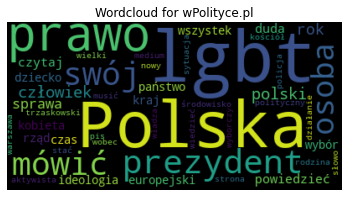

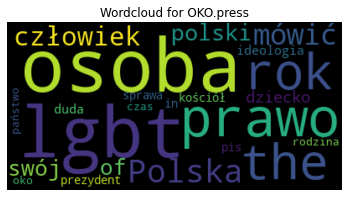

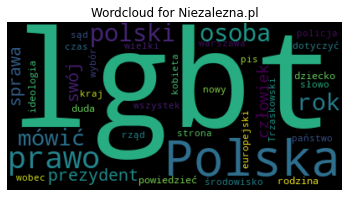

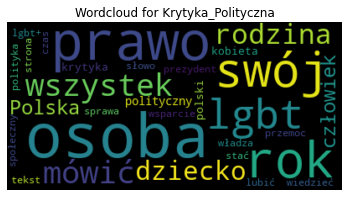

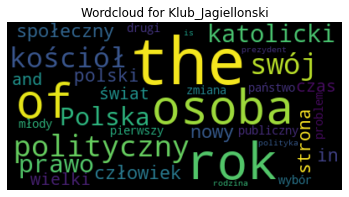

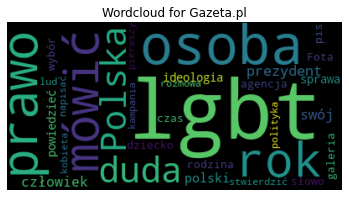

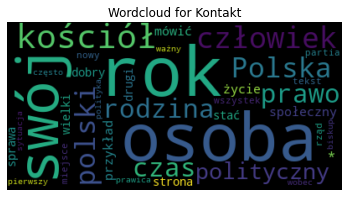

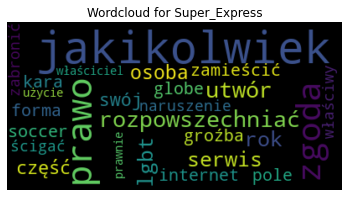

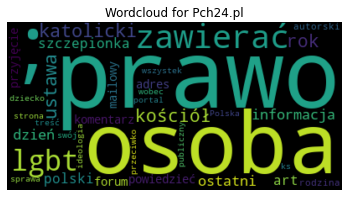

In [9]:
frequency = {}

for key, value in data_dict.items():
    frequency[key] = make_wordclouds(value,key)

In [10]:
pd.Series(frequency["wPolityce.pl"]).sort_values(ascending=False).head(50)

lgbt           3587
Polska         2866
prawo          2562
prezydent      2186
swój           2014
mówić          1982
osoba          1871
polski         1777
człowiek       1777
rok            1646
sprawa         1516
powiedzieć     1369
duda           1357
czytaj         1324
ideologia      1162
dziecko        1146
rząd           1121
państwo        1044
europejski     1026
wybór          1009
kobieta         990
kraj            981
wszystek        973
czas            955
polityczny      948
nowy            942
pis             924
strona          921
aktywista       888
środowisko      867
rodzina         854
wielki          844
trzaskowski     840
słowo           834
wobec           762
działanie       746
wyborczy        745
kościół         723
warszawa        720
władza          715
musić           707
sytuacja        697
medium          692
stać            682
policja         681
wiedzieć        677
opozycja        674
sąd             670
lewica          659
świat           658


In [11]:
pd.Series(frequency["OKO.press"]).sort_values(ascending=False).head(50)

osoba         1734
lgbt          1565
prawo         1530
rok           1306
the           1249
Polska         991
mówić          955
człowiek       864
polski         861
swój           823
of             797
dziecko        708
ideologia      665
duda           663
sprawa         597
in             583
prezydent      571
kościół        566
pis            539
rodzina        497
państwo        495
oko            495
czas           468
wszystek       447
europejski     439
władza         434
press          431
and            413
publiczny      394
polityczny     372
kraj           361
słowo          357
działanie      352
powiedzieć     347
strona         345
sąd            343
kampania       342
wobec          338
pierwszy       335
miasto         332
wybór          332
rząd           324
społeczny      324
równość        321
wielki         320
seksualny      318
2019           309
policja        307
wartość        307
uchwała        303
dtype: int64

Simple frequencies do not show much variety in language used in articles from different media. This part of analysis shows that the media relate to the same events, such as presidential elecion, that were prominent in discussion about LGBT+ community in Poland in 2020.

#### 2.3 Looking for common collocations

In [12]:
# creating a dictionary for collocations in each data frame

collocations = {}
# reading tokens from processed data for each data frame
for key in data_dict:
    collocations[key] = find_collocations_bigram(data_dict[key])

In [13]:
for key in collocations:
    print(f"Common collocations for {key}")
    for attribute, value in collocations[key].items():
        print(f"{attribute}:{value}")
    print("\n\n ---------------------------")


Common collocations for wPolityce.pl
('andrzej', 'duda'):(862.9999999999999, 0.001271867124519181)
('aktywista', 'lgbt'):(556.0, 0.0008194184487052893)
('ideologia', 'lgbt'):(464.0, 0.0006838312233799537)
('michał', 'sz'):(416.00000000000006, 0.0006130900623406482)
('rafały', 'trzaskowski'):(381.00000000000006, 0.0005615079657494879)
('prezydent', 'andrzej'):(361.0, 0.0005320324819831105)
('środowisko', 'lgbt'):(324.0, 0.0004775028370153125)
('prawo', 'człowiek'):(314.0, 0.0004627650951321239)
('rafał', 'trzaskowski'):(293.0, 0.0004318158371774277)
('osoba', 'lgbt'):(289.0, 0.0004259207404241522)
('strefa', 'wolny'):(276.0, 0.00040676167597600694)
('gazeta', 'wyborczy'):(268.0, 0.000394971482469456)
('prezydent', 'duda'):(247.0, 0.00036402222451475984)
('unia', 'europejski'):(240.0, 0.0003537058051965278)
('tęczowy', 'flaga'):(223.0, 0.0003286516439951071)
('krakowski', 'przedmieście'):(220.99999999999997, 0.0003257040956184693)
('portal', 'wpolitycepl'):(206.99999999999997, 0.00030507

Most common bigram collocations show much more differences. For example, one of the most common collocation in right wing outlets, like wPolityce.pl and Niezalezna.pl is Michał Sz., deliberate misgendering of LGBT activist Margot. There are also numerous mentions of "Figura Chrystusa", refering to an act of hanging rainbow flag on one of Christ monuments in Warsaw, seen as act of desacration. There are also mentions of "gender ideology", right wing term for modern emancipation movements. Pope John Paul II is frequently brought up, much more often than polish Prime Minister. Right wing media often refers to offence of religious beliefs, where left wing outlets more frequently bring up hate speech. There are also mentions of marriage equality, human rights, gender identity, heteronormativity and so on. This material could be used to more detailed qualitative analysis.

In [14]:
# creating trigram collocations
# defining punctuation, creating a dictionary for collocations in each data frame
collocations_trigram = {}

# reading tokens from processed data in each data frame
for key in data_dict:
    collocations_trigram[key] = find_collocations_trigram(data_dict[key])

In [15]:
for key in collocations_trigram:
    print(f"Common collocations for {key}")
    for attribute, value in collocations_trigram[key].items():
        print(f"{attribute}:{value}")
    print("\n\n ---------------------------")


Common collocations for wPolityce.pl
('prezydent', 'andrzej', 'duda'):(360.00000000000006, 0.0005305587077947917)
('jan', 'paweł', 'ii'):(121.0, 0.00017832667678658275)
('rzecznik', 'prawo', 'obywatelski'):(108.0, 0.0001591676123384375)
('von', 'dera', 'leyen'):(83.00000000000001, 0.00012232325763046587)
('michał', 'sz', 'margot'):(71.0, 0.00010463796737063947)
('łódzki', 'kurator', 'oświata'):(63.0, 9.284777386408855e-05)
('prawo', 'osoba', 'lgbt'):(49.0, 7.221493522762443e-05)
('premiera', 'mateusz', 'morawiecki'):(48.0, 7.074116103930555e-05)
('ii', 'wojna', 'światowy'):(47.0, 6.92673868509867e-05)
('tura', 'wybór', 'prezydencki'):(47.0, 6.92673868509867e-05)
('zły', 'strona', 'historia'):(47.0, 6.92673868509867e-05)
('mówić', 'portal', 'wpolitycepl'):(45.00000000000001, 6.631983847434897e-05)
('jany', 'pawła', 'ii'):(42.99999999999999, 6.337229009771122e-05)
('św', 'jan', 'paweł'):(42.99999999999999, 6.337229009771122e-05)
('radio', 'nowy', 'świat'):(41.0, 6.04247417210735e-05)
('r

Numerous other differences, indicating ideological difference can be found in trigram collocations. Again, right wing press very often invokes deceased polish pope, misgenders Margot, talk about desacration, offence of religious beliefs and deviation. Most often mentioned university is Catholic University of Lublin. There are mentions of lgbt provocations, destruction of property and deception. Left leaning ones make more mentions of lgbt+ rights, discrimination, and mention multiple NGOs. Again, this data could be a valuable base for further qualitative analysis

##### 2.3.2 Looking for collocations with the term LGBT

In [16]:
# looking for collocations with lgbt related terms

collocations_lgbt = {}
# reading tokens from processed data for each data frame
for key in data_dict:
    collocations_lgbt[key] = find_collocations_trigram(data_dict[key],key="lgbt")

In [17]:
collocations_lgbt["wPolityce.pl"]

{('prawo', 'osoba', 'lgbt'): (49.0, 7.221493522762443e-05),
 ('lgbt', 'zbezcześcić', 'figura'): (33.0, 4.8634548214522574e-05),
 ('działacz', 'lgbt', 'zbezcześcić'): (32.0, 4.71607740262037e-05),
 ('hucpa', 'działacz', 'lgbt'): (31.0, 4.568699983788484e-05),
 ('prowokacja', 'aktywista', 'lgbt'): (29.0, 4.273945146124711e-05),
 ('wprowadzić', 'karta', 'lgbt'): (28.0, 4.126567727292824e-05),
 ('wobec', 'ideologia', 'lgbt'): (24.999999999999996, 3.684435470797164e-05),
 ('ambasador', 'ws', 'lgbt'): (24.0, 3.537058051965278e-05),
 ('lgbt', 'michał', 'sz'): (24.0, 3.537058051965278e-05),
 ('ws', 'społeczność', 'lgbt'): (24.0, 3.537058051965278e-05),
 ('przedmieście', 'aktywista', 'lgbt'): (21.0, 3.094925795469618e-05),
 ('wobec', 'osoba', 'lgbt'): (21.0, 3.094925795469618e-05)}

#### 2.2 and 2.3 summary
Obtained data containing common collocations in texts from different sites, including collocations with the term lgbt, can be used in qualitative analysis. By showing how commonly used expressions are positively or negatively charged and investigating metaphors they portray we can reconstruct how these text influence readers. More advanced machine learning models, such as neural networks trained for sentiment analysis of sentences or collocations could be employed in such work.

### 3. Does right wing newspapers have distinctly different style than left leaning ones?
#### Classification using machine learning models

Learning will be done on three most distinctly right-leaning portals in the corpus: wPolityce.pl, Niezalezna.pl and PCH24.pl and three most distinctly left wing: OKO.press, Krytyka Polityczna and Kontakt. Left wing part will be significantly smaller than the right wing, so the training set will not be perfectly balanced. Training model on atricles from different sites will provide variety of languages used. Final model can be used to mark articles on lgbt issues to check if the language used is closer to the left-wing coverage (more lgbt friendly) or right-wing one (hostile towards lgbt community).

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer

import pprint
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from sklearn.metrics import accuracy_score,f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import pickle

In [19]:
# preparing learning set from texts
keys_right = ["Pch24.pl","wPolityce.pl","Niezalezna.pl"]
keys_left = ["OKO.press","Kontakt","Krytyka_Polityczna"]

# learning dataframe has two values, ideological side of the text publisher and article text
learning_set = pd.DataFrame({"Side":[], "Text":[]})
learning_set

# preparing articles from right leaning outlets
for key in keys_right:
    texts = data_dict[key].Content
    frame = pd.DataFrame({"Side":"right","Text":texts})
    learning_set = learning_set.append(frame,ignore_index=True)

# preparing articles from left leaning outlets
for key in keys_left:
    texts = data_dict[key].Content
    frame = pd.DataFrame({"Side":"left","Text":texts})
    learning_set = learning_set.append(frame,ignore_index=True)

In [21]:
# Clearing texts from portal names, references, footers etc

learning_set = clearing_texts(learning_set)
    

NameError: name 'i' is not defined

In [ ]:
# creating variables, defining training and testing sets
X = learning_set.Text
y = learning_set.Side
# changing labels to numerical values
y = y.map({"right":0,"left":1})
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [ ]:
"""
creating grid search to find the best classification model
every model uses count vectorizer to change texts into numerical vectors
I'm not using vectors provided by Spacy in earlier preprocessing, because CountVectorizer can be fitted into a pipeline and is
easier to process by classification models. Spacy vectors caused problems in fitting phase of learning.
"""
pipelines = [make_pipeline(CountVectorizer(),LogisticRegression(solver="liblinear")), # Logistic Regression
            make_pipeline(CountVectorizer(),DecisionTreeClassifier()),                # Decision Tree
            make_pipeline(CountVectorizer(),MultinomialNB()),                         # Naive Bayes
            make_pipeline(CountVectorizer(),SVC()),                                   # SVM
            make_pipeline(CountVectorizer(),SVC()),                                   # SVM2
            make_pipeline(CountVectorizer(),RandomForestClassifier())]                     # Bagging Classifier

# Defining parameters to check for each defined model
param_grids = [{"logisticregression__penalty":["l1","l2"],"logisticregression__C":[0.001,0.01,0.1,1,10,100,1000]},
              {"decisiontreeclassifier__criterion":["gini","entropy"],"decisiontreeclassifier__min_samples_split":[2,4,6,8,10]},
              {"multinomialnb__fit_prior":[True,False],"multinomialnb__alpha":[0.1,0.3,0.5,0.7,0.9]},
              {"svc__kernel":["rbf"],"svc__C":[0.01,0.1,1,10,100,1000,10000],"svc__gamma":[0.1,0.2,1,10,20,50]},
              {"svc__kernel":["poly"],"svc__C":[0.01,0.1,1,10,100,1000,10000,100000],"svc__degree":[1,2,3]},
              {"randomforestclassifier__criterion":["gini","entropy"],
              "randomforestclassifier__n_estimators":[100,200,300], "randomforestclassifier__min_samples_split":[2,4,6,8,10]}]

In [ ]:
# using grid search cv to find the best model

# defining variables to store parameters and scores for the best model
best_model = ""
best_params = ""
score_f1 = 0
acc_score = 0

# testing in a loop for each pipeline - parameters combination
for i in range(len(pipelines)):
    
    # Creating GridSearch object
    grid = GridSearchCV(pipelines[i],
                        param_grid=param_grids[i],
                        refit=True,      # refitting best model
                        cv = 5,          # nr of crossvalidations
                        verbose=3,       # provides information during the learning process
                        n_jobs = 3)      # nr of cores used for testing
    
    # Fitting data
    grid.fit(X_train,y_train)
    
    # Predicting on test data, scoring
    y_pred = grid.predict(X_test)
    test_f1 = f1_score(y_test,y_pred)
    test_acc = accuracy_score(y_test,y_pred)
    
    # Checking if model is better than current best, declaring new values if it is
    if test_acc > acc_score:
        acc_score = test_acc
        score_f1 = test_f1
        best_model = pipelines[i]
        best_params = grid.best_params_
        

# printing best model 
print(f"Best model: {best_model} with {best_params} parameters. F1 score = {score_f1} and Accuracy score = {acc_score}")

In [34]:
# retraining best model on whole dataset:

model = best_model.fit(X,y)

NameError: name 'test_f1' is not defined

In [44]:
# Saving trained best model

filename = 'Ideological_text_classifier_lgbt.sav'
pickle.dump(model,open(filename, 'wb'))

In [36]:
filename = 'Ideological_text_classifier_lgbt.sav'

loaded_model = pickle.load(open(filename, 'rb'))

In [45]:
gazetapl = []
for i in range(len(data_dict["Gazeta.pl"].Content)):
    for word, initial in dict_replacements.items():
        gazetapl.append(data_dict["Gazeta.pl"].Content[i].lower().replace(word.lower(), initial))

In [37]:
preds = loaded_model.predict(X)
f1_score(y,preds)

1.0

Almost all classifiers yielded very good results in classificating texts, indicating that there is significant difference between right and left wing press in regards to lgbt+ community. This model can be employed to check wether new texts use aggressive and hostile or more empathetic language.